# Delay Relaxation and Cross Talk Errors
#### Ethan Dickey, Quantum Research Intern (Master's): Summer 2021
#### POC: Chris Wood

This notebook adds a customized `DelayAerSimulator` backend that extends `AerSimulator` to support simulation of both *parameterized delay noise* and *cross talk noise* in scheduled circuits.

It also provides a structure for adding generalized parameterized noise to a circuit (a functionality not currently supported by Qiskit simulators).

## Motivation

Recently, the ability to schedule circuits was added to qiskit to reason about the duration and timing of instructions in circuits.  Scheduling a circuit, among other things, adds (duration-) parameterized delay gates into a circuit when a qubit is idle.  However, presently none of the simulators in qiskit have a way to add parameterized noise to a noise model.  They simply add noise based on the gates present in the circuit.  In addition, they don't have noise based on cross talk (when multiple connected qubits are in a delay).  This notebook demonstrates both a method to add single-qubit parameterized thermal relaxation errors as well as a method to add cross talk errors to a simulation.

Having these delay-based errors in a circuit is important for accurate noisy simulations as delays are a prolific part of every scheduled circuit.  For example, in a simple 4-qubit GHZ circuit, scheduling adds 6 delays.  In the first circuit drawing, you can see the many delays added to the original circuit.  For a different perspective, in the second circuit drawing everywhere there is grey is where scheduling adds a delay.

In [3]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
_delay_ex_backend = FakeVigo()

# Make a cirucit
_qc = QuantumCircuit(4)
_qc.h(0)
_qc.cx(0, 1)
_qc.cx(1, 2)
_qc.cx(2, 3)

# Schedule
_sched_circ = transpile(_qc, _delay_ex_backend, scheduling_method='alap')
_sched_circ.draw(fold=-1)

┌─────────────────┐                                                                         ┌───┐       
      q_3 -> 0 ┤ DELAY(7520[dt]) ├─────────────────────────────────────────────────────────────────────────┤ X ├───────
               └─────────────────┘    ┌───┐                            ┌───┐       ┌───┐                   └─┬─┘       
      q_2 -> 1 ─────────■─────────────┤ X ├─────■──────────────────────┤ X ├───────┤ X ├─────────■───────────■─────────
                      ┌─┴─┐           └─┬─┘   ┌─┴─┐ ┌─────────────────┐└─┬─┘       └─┬─┘       ┌─┴─┐┌─────────────────┐
      q_1 -> 2 ───────┤ X ├─────────────■─────┤ X ├─┤ DELAY(2080[dt]) ├──┼───────────■─────────┤ X ├┤ DELAY(2496[dt]) ├
               ┌──────┴───┴──────┐ ┌─────────┐├───┴┐└───┬─────────┬───┘  │  ┌─────────────────┐└───┘└─────────────────┘
      q_0 -> 3 ┤ DELAY(3072[dt]) ├─┤ RZ(π/2) ├┤ √X ├────┤ RZ(π/2) ├──────■──┤ DELAY(4704[dt]) ├────────────────────────
               ├─────────────────┴┐└─────────┘└────┘    └─────────┘         └─────────────────┘                        
ancilla_0 -> 4 ┤ DELAY(10016[dt]) ├────────────────────────────────────────────────────────────────────────────────────
               └──────────────────┘

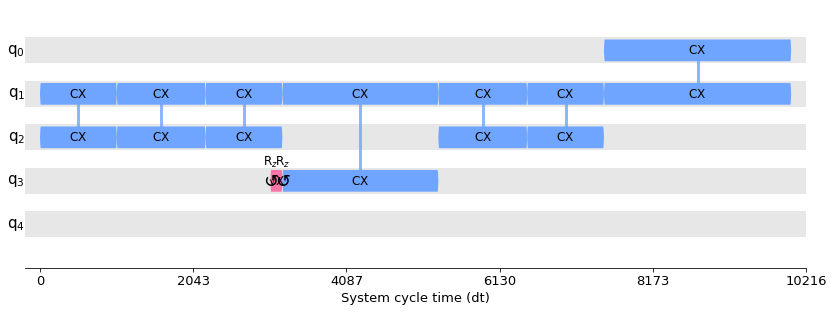

In [2]:
draw(_sched_circ)

## Implementation

The from_backend function allows this custom simulator to run additional passes after the circuit has been transpiled.  The two passes run are DelayReplace and CrossTalkDelayReplace

### DelayReplace

During this pass, analysis data regarding the delays and their durations is added to the circuit metadata.  This pass then adds a custom label to each delay gate so that the noise model can recognize delay errors based on their unique durations.

### CrossTalkDelayReplace

This pass first identifies when any qubit delay starts or stops and then uses that information to split all delays so that all delays line up.  This allows the pass to then efficiently detect when two delays start together and add cross talk if they are connected according to the coupling map.